In [1]:
import random 
from random import sample, seed, shuffle
import numpy as np
import pandas as pd
import os
import six
from rdkit import rdBase
from rdkit import RDLogger

# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

#utility functions : prepare the data 
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands, prepare_df_chemeleon
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates

#utility functions : CV and results 
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results
from model_fp_selection.lib.utils import df_split, get_indices, get_indices_doi, get_indices_scaff
from model_fp_selection.lib.utils import generate_scaffold, scaffold_to_smiles
from model_fp_selection.lib.utils import ligands_permutation, cross_validation, prepare_train_set


from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

#Encoding categorical Data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipelines and other model constructions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#np.random.seed(42)
#seed(42)

#Specific to Scaffold Splitting
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import pickle as pkl
import time
from tqdm import tqdm
import seaborn as sns

from itertools import *

In [2]:
metals = pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})

In [3]:
l=len(metals)
metals_chemeleon_1 = prepare_df_chemeleon(metals[0:int(0.33*l)])

In [4]:
metals_chemeleon_2 = prepare_df_chemeleon(metals[int(0.33*l):int(0.66*l)])

In [5]:
metals_chemeleon_3 = prepare_df_chemeleon(metals[int(0.66*l):l])
metals_chemeleon = pd.concat([metals_chemeleon_1, metals_chemeleon_2, metals_chemeleon_3], ignore_index=True)
metals_chemeleon = average_duplicates(metals_chemeleon, 'Ligands_Dict', 'pIC50')

Length of training dataset after cleaning duplicates, before adding permutations : 718


# Training the model

Bayesian Optimisation allowed us to get the best hyperparameters for the random forest model, depending on the Fingerprint used.

In [6]:
rf_chemeleon = RandomForestRegressor(max_depth=28, n_estimators=210, min_samples_leaf=1, max_features=0.8, random_state=42)

### Random Splitting

#### On the whole dataset, Chemeleon fingerprints

In [11]:
X = np.array(metals_chemeleon['Descriptors'].values.tolist())
y = np.array(metals_chemeleon['pIC50'].values.tolist())

indices_chemeleon = get_indices(metals_chemeleon, CV=10, shuffle=True)

train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 646 | test length : 72
train length : 647 | test length : 71
train length : 647 | test length : 71


In [12]:
y_data_chemeleon, y_predictions_chemeleon = cross_validation(metals_chemeleon, indices_chemeleon, X, y, rf_chemeleon)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.347616670811599, 'RMSE': 0.4787025654632871, 'Ratio': 1.3770989876453132, 'R² Score': 0.6705954031856163}


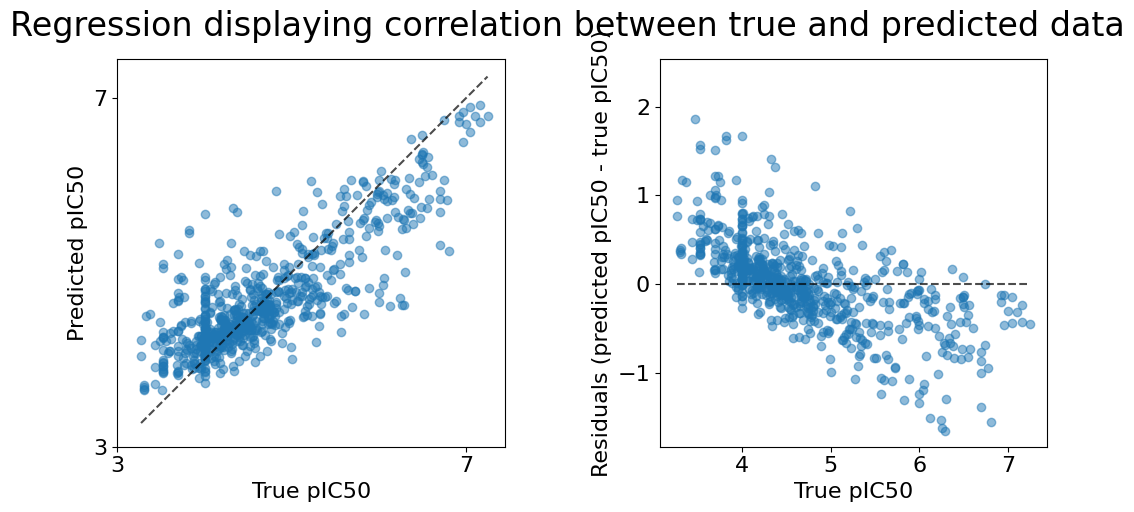

In [13]:
plot_cv_results(y_data_chemeleon, y_predictions_chemeleon, log=True)

#### On HeLa, Chemeleon fingerprints

In [7]:
metals_chemeleon_hela = metals_chemeleon[metals_chemeleon['Cells'] == 'HeLa']
metals_chemeleon_hela.reset_index(drop=True, inplace=True)

X_hela = np.array(metals_chemeleon_hela['Descriptors'].values.tolist())
y_hela = np.array(metals_chemeleon_hela['pIC50'].values.tolist())

indices_chemeleon_hela = get_indices(metals_chemeleon_hela, CV=10, shuffle=True)

train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 164 | test length : 19
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18
train length : 165 | test length : 18


In [9]:
y_data_chemeleon_hela, y_predictions_chemeleon_hela = cross_validation(metals_chemeleon_hela, indices_chemeleon_hela, 
                                                                       X_hela, y_hela, rf_chemeleon)


CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.30625164309841835, 'RMSE': 0.424011089066142, 'Ratio': 1.3845185768681083, 'R² Score': 0.42810810038505975}


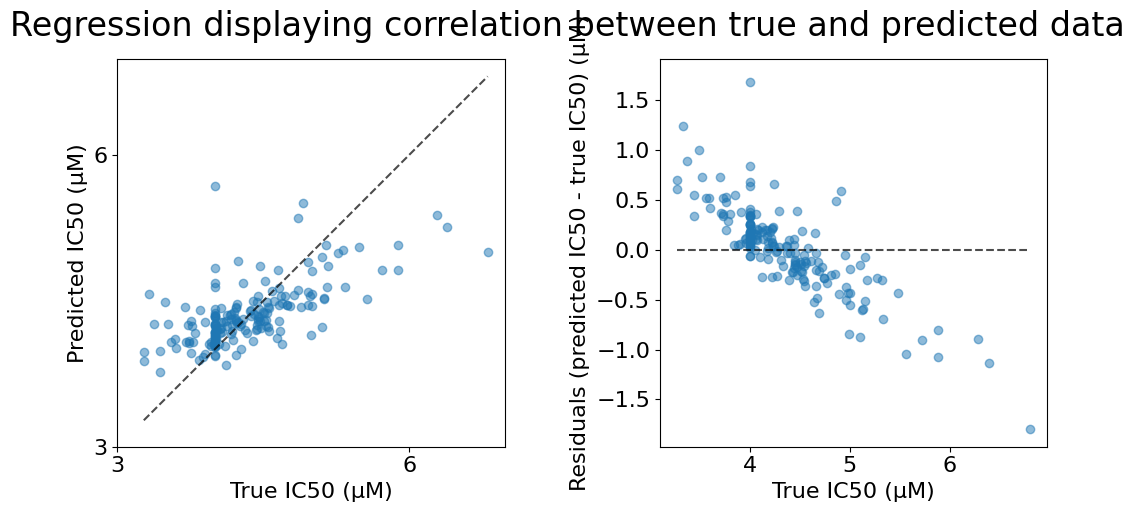

In [10]:
plot_cv_results(y_data_chemeleon_hela, y_predictions_chemeleon_hela)

## DOI Splitting

#### On the whole dataset, Chemeleon fingerprints

In [11]:
X_chemeleon_doi = np.array(metals_chemeleon['Descriptors'].values.tolist())
y_chemeleon_doi = np.array(metals_chemeleon['pIC50'].values.tolist())

indices_chemeleon_doi = get_indices_doi(metals_chemeleon, CV=10)

fold 0 groups: train 200 test 20
fold 0 train set : 646 | test set : 72
fold 1 groups: train 198 test 22
fold 1 train set : 646 | test set : 72
fold 2 groups: train 198 test 22
fold 2 train set : 646 | test set : 72
fold 3 groups: train 198 test 22
fold 3 train set : 646 | test set : 72
fold 4 groups: train 198 test 22
fold 4 train set : 646 | test set : 72
fold 5 groups: train 198 test 22
fold 5 train set : 646 | test set : 72
fold 6 groups: train 197 test 23
fold 6 train set : 646 | test set : 72
fold 7 groups: train 197 test 23
fold 7 train set : 646 | test set : 72
fold 8 groups: train 198 test 22
fold 8 train set : 647 | test set : 71
fold 9 groups: train 198 test 22
fold 9 train set : 647 | test set : 71


In [12]:
y_data_chemeleon_doi, y_predictions_chemeleon_doi = cross_validation(metals_chemeleon,
                                                                 indices_chemeleon_doi, X_chemeleon_doi,
                                                                 y_chemeleon_doi, rf_chemeleon)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5032834314813618, 'RMSE': 0.6675154820797466, 'Ratio': 1.3263211946298035, 'R² Score': 0.35949749662653396}


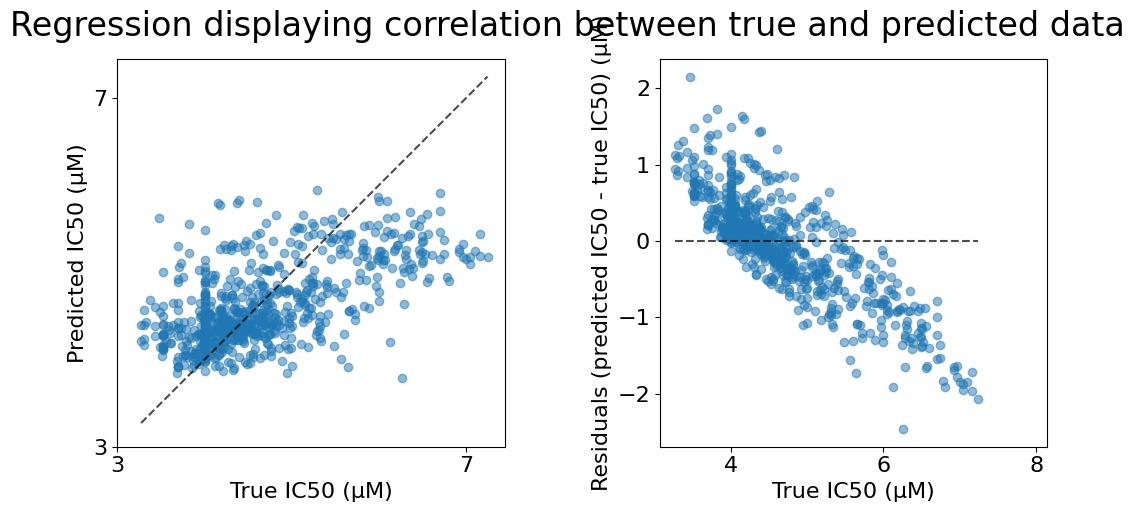

In [13]:
plot_cv_results(y_data_chemeleon_doi, y_predictions_chemeleon_doi)

## Scaffold Splitting

#### Scaffold for ligand A, Chemeleon fingerprints

In [14]:
metals_A = metals_chemeleon.copy()
metals_A.reset_index(drop=True, inplace=True)

X_A = np.array(metals_A['Descriptors'].values.tolist())
y_A = np.array(metals_A['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsA = metals_A['MOL1'].tolist()

indicesA = get_indices_scaff(molsA, CV=10)

100%|██████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 2863.92it/s]

train length : 651 | test length : 67
train length : 689 | test length : 29
train length : 684 | test length : 34
train length : 701 | test length : 17
train length : 706 | test length : 12
train length : 712 | test length : 6
train length : 507 | test length : 211
train length : 705 | test length : 13
train length : 709 | test length : 9
train length : 398 | test length : 320


In [15]:
y_dataA, y_predictionsA = cross_validation(metals_A, indicesA, X_A, y_A, rf_chemeleon)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.5363093591790566, 'RMSE': 0.7475224691114167, 'Ratio': 1.3938270073370895, 'R² Score': 0.19675755759431124}


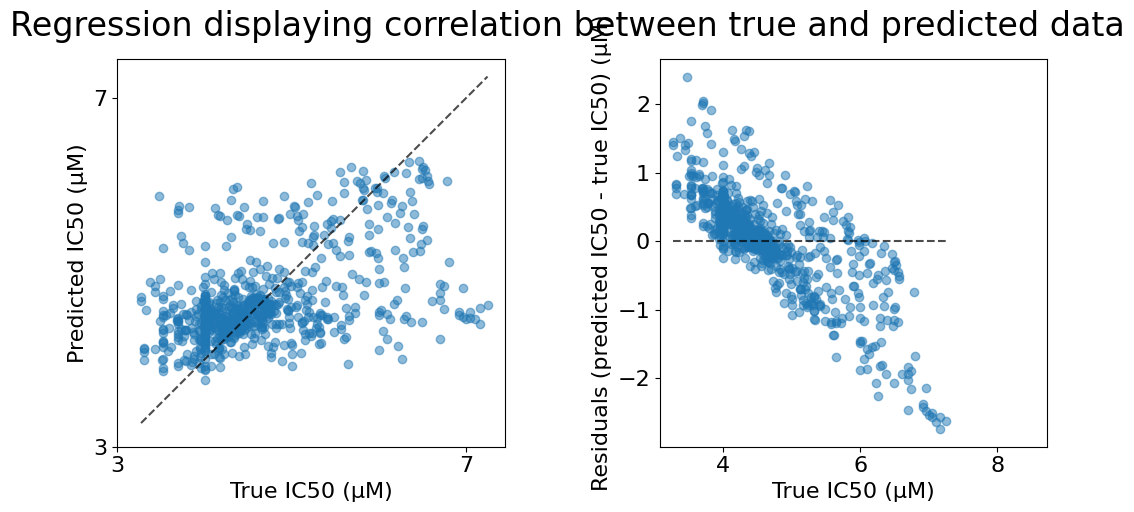

In [16]:
plot_cv_results(y_dataA, y_predictionsA)

#### Scaffold for ligand B, Chemeleon fingerprints

In [17]:
metals_B = metals_chemeleon.copy()
metals_B.reset_index(drop=True, inplace=True)

X_B = np.array(metals_B['Descriptors'].values.tolist())
y_B = np.array(metals_B['pIC50'].values.tolist())

# We must extract the mol objects as the get_indices_scaff take a list of mol objects as argument, not a dataframe
molsB = metals_B['MOL3'].tolist()

indicesB = get_indices_scaff(molsB, CV=10)

100%|██████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 3174.35it/s]

train length : 676 | test length : 42
train length : 577 | test length : 141
train length : 672 | test length : 46
train length : 594 | test length : 124
train length : 673 | test length : 45
train length : 677 | test length : 41
train length : 601 | test length : 117
train length : 647 | test length : 71
train length : 674 | test length : 44
train length : 671 | test length : 47


In [18]:
y_dataB, y_predictionsB = cross_validation(metals_B, indicesB, X_B, y_B, rf_chemeleon)

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
{'MAE': 0.4833278807629802, 'RMSE': 0.6367154595157045, 'Ratio': 1.3173571913761462, 'R² Score': 0.4172410731027465}


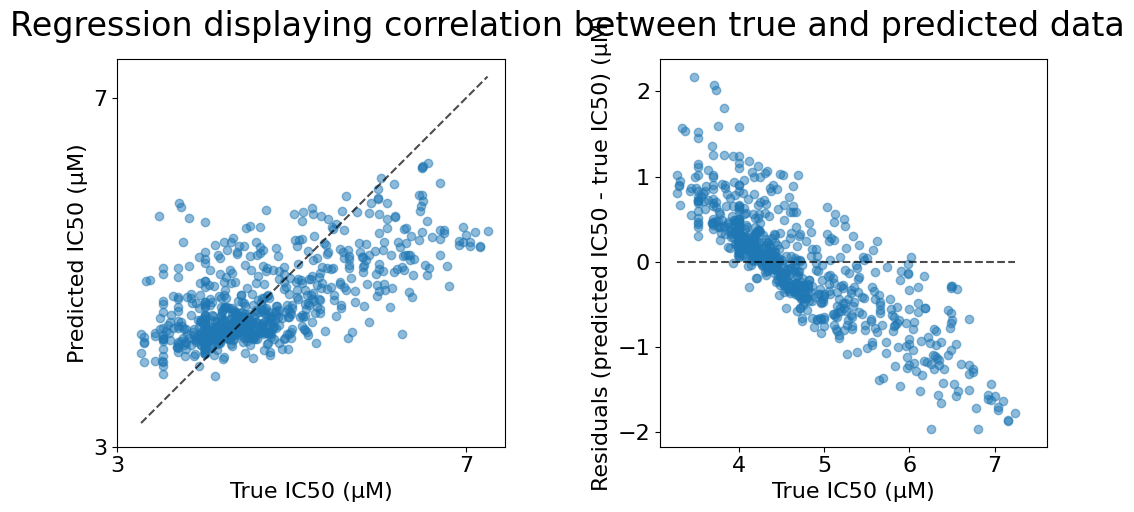

In [19]:
plot_cv_results(y_dataB, y_predictionsB)